Продвинутое машинное обучение: 

Домашнее задание 2

Второе домашнее задание — самое большое в курсе, в нём придётся и концептуально подумать о происходящем, и технические трудности тоже порешать. Как и раньше, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Как всегда, любые комментарии, новые идеи и рассуждения на тему категорически приветствуются. 

Второе задание — это полноценный проект по анализу данных, начиная от анализа постановки задачи и заканчивая сравнением результатов разных моделей. Задача реальная и серьёзная, хотя тему я выбрал развлекательную: мы будем строить вероятностную рейтинг-систему для спортивного “Что? Где? Когда?” (ЧГК).

Background: в спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд. Соответственно, нам нужно:
* построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров;
* при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и т.д.; поэтому единицей рейтинг-листа должна быть не команда, а отдельный игрок;
* а что сильно упрощает задачу и переводит её в область домашних заданий на EM-алгоритм — это характер данных: начиная с какого-то момента, в базу результатов начали вносить все повопросные результаты команд, т.е. в данных будут записи вида “какая команда на какой вопрос правильно ответила”.

Я сделал за вас только первый шаг: выкачал через API сайта рейтинга ЧГК все нужные данные, чтобы сайт не прилёг под вашими многочисленными скрейперами. :) Полученные данные лежат в формате pickle вот здесь:

https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip 


In [1]:
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.sparse
from sklearn.linear_model import LogisticRegression, LinearRegression

1.	Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
* взять в тренировочный набор турниры с dateStart из 2019 года; 
* в тестовый — турниры с dateStart из 2020 года.

In [2]:
with open('chgk/players.pkl', 'rb') as file:
    players = pickle.load(file)
    
dict(list(players.items())[:1])

{1: {'id': 1, 'name': 'Алексей', 'patronymic': None, 'surname': 'Абабилов'}}

In [3]:
players = pd.DataFrame.from_dict(players, orient='index')
players.head()

,id,name,patronymic,surname
1,1,Алексей,None,Абабилов
10,10,Игорь,,Абалов
11,11,Наталья,Юрьевна,Абалымова
12,12,Артур,Евгеньевич,Абальян
13,13,Эрик,Евгеньевич,Абальян


In [4]:
with open('chgk/tournaments.pkl', 'rb') as file:
    tournaments = pickle.load(file)

dict(list(tournaments.items())[:1])

{1: {'id': 1,
  'name': 'Чемпионат Южного Кавказа',
  'dateStart': '2003-07-25T00:00:00+04:00',
  'dateEnd': '2003-07-27T00:00:00+04:00',
  'type': {'id': 2, 'name': 'Обычный'},
  'season': '/seasons/1',
  'orgcommittee': [],
  'synchData': None,
  'questionQty': None}}

In [5]:
tournaments = pd.DataFrame.from_dict(tournaments, orient='index')
tournaments.head()

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
1,1,Чемпионат Южного Кавказа,2003-07-25T00:00:00+04:00,2003-07-27T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
2,2,Летние зори,2003-08-09T00:00:00+04:00,2003-08-09T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
3,3,Турнир в Ижевске,2003-11-22T00:00:00+03:00,2003-11-24T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
4,4,Чемпионат Украины. Переходной этап,2003-10-11T00:00:00+04:00,2003-10-12T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
5,5,Бостонское чаепитие,2003-10-10T00:00:00+04:00,2003-10-13T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None


In [6]:
tournaments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5528 entries, 1 to 6485
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5528 non-null   int64 
 1   name          5528 non-null   object
 2   dateStart     5528 non-null   object
 3   dateEnd       5528 non-null   object
 4   type          5528 non-null   object
 5   season        5434 non-null   object
 6   orgcommittee  5528 non-null   object
 7   synchData     1855 non-null   object
 8   questionQty   4343 non-null   object
dtypes: int64(1), object(8)
memory usage: 431.9+ KB


In [7]:
tournaments['dateStart'] = pd.to_datetime(tournaments['dateStart'], utc=True)
tournaments['dateStart'] = pd.DatetimeIndex(tournaments['dateStart']).year
tournaments = tournaments[tournaments['dateStart'].isin((2019, 2020))]

tournaments_2019 = tournaments[tournaments['dateStart'] == 2019]['id'].to_list()
tournaments_2020 = tournaments[tournaments['dateStart'] == 2020]['id'].to_list()

tour_ids = tournaments_2019.copy()
tour_ids.extend(tournaments_2020.copy())

tournaments = tournaments[['id', 'name', 'dateStart']]
tournaments.set_index('id', drop=True, inplace=True)
tournaments = tournaments.to_dict(orient='index')

In [8]:
with open('chgk/results.pkl', 'rb') as file:
    results = pickle.load(file)
    
dict(list(results.items())[:1])

{1: [{'team': {'id': 242,
    'name': 'Команда Азимова',
    'town': {'id': 21, 'name': 'Баку'}},
   'mask': None,
   'current': {'name': 'Команда Азимова', 'town': {'id': 21, 'name': 'Баку'}},
   'questionsTotal': 0,
   'synchRequest': None,
   'position': 1,
   'controversials': [],
   'flags': [],
   'teamMembers': [{'flag': None,
     'usedRating': 0,
     'rating': 0,
     'player': {'id': 476,
      'name': 'Анар',
      'patronymic': 'Беюкага оглы',
      'surname': 'Азимов'}},
    {'flag': None,
     'usedRating': 0,
     'rating': 0,
     'player': {'id': 878,
      'name': 'Фариз',
      'patronymic': 'Наим оглы',
      'surname': 'Аликишибеков'}},
    {'flag': None,
     'usedRating': 0,
     'rating': 0,
     'player': {'id': 1872,
      'name': 'Аднан',
      'patronymic': 'Фариз оглы',
      'surname': 'Ахундов'}},
    {'flag': None,
     'usedRating': 0,
     'rating': 0,
     'player': {'id': 13721,
      'name': 'Балаш',
      'patronymic': 'Алекпер оглы',
      'surna

In [9]:
def forming_teams(results):
    teams = dict()
    
    for tournament in results.values():
        for team in tournament:
            team_id = team['team']['id']
            name = team['team']['name']
            teams[team_id] = name
            
    return teams

teams = forming_teams(results)

In [10]:
def filter_results_by_year_and_team(results, tournaments):
    res = dict()
    
    for tournament_id in results.keys():
        if tournament_id in tournaments.keys():
            name = tournaments[tournament_id]['name']
            teams = results[tournament_id]
            
            res[tournament_id] = {
                'name': name, 
                'teams': teams
            }
            
    res = {tournament_id: tournament for tournament_id, tournament in res.items() if tournament['teams']}
    
    return res


def filter_results_by_team_mask(results):
    SUITABLE_ANSWERS = {'1', '0', 'X'}
    
    for tournament_id, tournament in results.items():
        teams = []
        for team in tournament['teams']:
            if 'mask' in team.keys() and team['mask'] and set(team['mask']).issubset(SUITABLE_ANSWERS):
                teams.append(team)
        results[tournament_id]['teams'] = teams
        
    results = {tournament_id: tournament for tournament_id, tournament in results.items() if tournament['teams']}
    
    return results


def filter_results_by_answers(res):    
    for tour_id, tour in res.items():
        for idx, _ in enumerate(tour['teams']):
            res[tour_id]['teams'][idx]['mask'] = res[tour_id]['teams'][idx]['mask'].replace('X', '')
            
    res = {tour_id: tour for tour_id, tour in res.items() if len(set([len(t['mask']) for t in tour['teams']])) == 1}

    return res

In [11]:
def reforming_tournament_team_members(team_members):
    res_team_members = []

    for team_member in team_members:
        res_team_members.append(team_member['player']['id'])
                
    return res_team_members


def reforming_tournament_teams(teams):
    res_teams = dict()

    for team in teams:
        team_id = team['team']['id']
        mask = team['mask']
        position = team['position']
        team_members = reforming_tournament_team_members(team['teamMembers'])
        
        res_teams[team_id] = {
            'mask': mask,
            'position': position,
            'team_members': team_members
        }
                
    return res_teams


def reforming_results(results, tournaments):
    
    res = filter_results_by_year_and_team(results, tournaments)
    res = filter_results_by_team_mask(res)
    res = filter_results_by_answers(res)
    
    for tournament_id, tournament in res.items():
        res[tournament_id]['teams'] = reforming_tournament_teams(res[tournament_id]['teams'])
    
    return res

In [12]:
tournaments_results = reforming_results(results, tournaments)

In [13]:
results_train = {k: v for k, v in tournaments_results.items() if k in tournaments_2019}
results_test = {k: v for k, v in tournaments_results.items() if k in tournaments_2020}

In [14]:
print(f'Всего турниров: {len(tournaments_results)}')
print(f'Турниров в 2019 году: {len(results_train)}')
print(f'Турниров в 2020 году: {len(results_test)}')

Всего турниров: 831
Турниров в 2019 году: 664
Турниров в 2020 году: 167


In [15]:
teams_train = len(set([t for v in results_train.values() for t in v['teams'].keys()]))
teams_test = len(set([t for v in results_test.values() for t in v['teams'].keys()]))

mean_teams_train = np.mean([len(v['teams']) for v in results_train.values()])
mean_teams_test = np.mean([len(v['teams']) for v in results_test.values()])


print(f'Уникальных команд в 2019 году: {teams_train}')
print(f'Уникальных команд в 2020 году: {teams_test}')
print(f'Среднее количество команд в турнире 2019 года: {mean_teams_train:.2f}')
print(f'Среднее количество команд в турнире 2020 года: {mean_teams_test:.2f}')

Уникальных команд в 2019 году: 11439
Уникальных команд в 2020 году: 5745
Среднее количество команд в турнире 2019 года: 118.46
Среднее количество команд в турнире 2020 года: 125.18


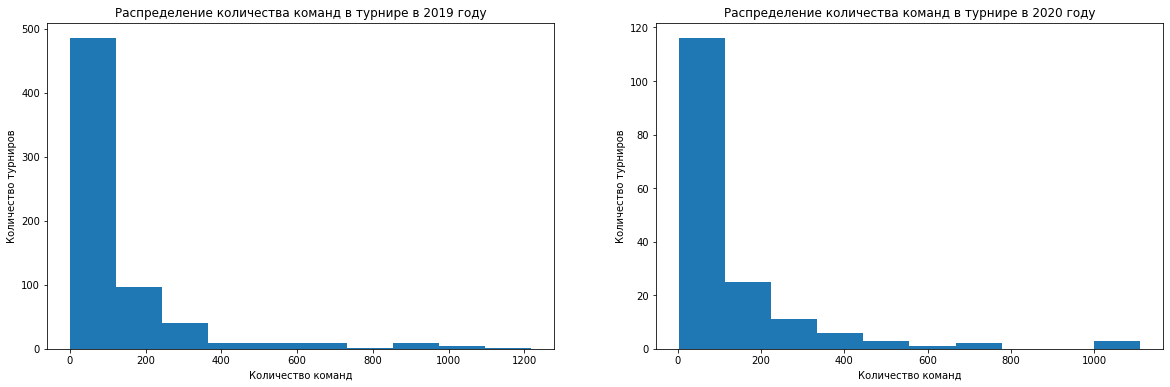

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

teams_in_tour_train = [len(v['teams']) for v in results_train.values()]
teams_in_tour_test = [len(v['teams']) for v in results_test.values()]

ax1.hist(teams_in_tour_train)
ax1.set_title('Распределение количества команд в турнире в 2019 году')
ax1.set_xlabel('Количество команд')
ax1.set_ylabel('Количество турниров')

ax2.hist(teams_in_tour_test)
ax2.set_title('Распределение количества команд в турнире в 2020 году')
ax2.set_xlabel('Количество команд')
ax2.set_ylabel('Количество турниров');

In [17]:
def player_teams_cnt(results_dict):
    players_teams = defaultdict(set)
    for v in results_dict.values():
        for k, t in v['teams'].items():
            for p in t['team_members']:
                players_teams[p].add(k)
    return [len(x) for x in players_teams.values()]

In [18]:
def player_tours_cnt(results_dict):
    players_tours = defaultdict(set)
    for k, v in results_dict.items():
        for t in v['teams'].values():
            for p in t['team_members']:
                players_tours[p].add(k)
    return [len(x) for x in players_tours.values()]

In [19]:
players_train = len(set([p for v in results_train.values() for t in v['teams'].values() for p in t['team_members']]))
players_test = len(set([p for v in results_test.values() for t in v['teams'].values() for p in t['team_members']]))

mean_teams_size_train = np.mean([len(t['team_members']) for v in results_train.values() for t in v['teams'].values()])
mean_teams_size_test = np.mean([len(t['team_members']) for v in results_test.values() for t in v['teams'].values()])

mean_players_size_train = np.mean([np.sum([len(t['team_members']) for t in v['teams'].values()]) for v in results_train.values()])
mean_players_size_test = np.mean([np.sum([len(t['team_members']) for t in v['teams'].values()]) for v in results_test.values()])

mean_players_teams_train = np.mean(player_teams_cnt(results_train))
mean_players_teams_test = np.mean(player_teams_cnt(results_test))

mean_players_tours_train = np.mean(player_tours_cnt(results_train))
mean_players_tours_test = np.mean(player_tours_cnt(results_test))

print(f'Уникальных игроков в 2019 году: {players_train}')
print(f'Уникальных игроков в 2020 году: {players_test}')
print(f'Средний размер команды в турнире 2019 года: {mean_teams_size_train:.2f}')
print(f'Средний размер команды в турнире 2020 года: {mean_teams_size_test:.2f}')
print(f'Среднее количество игроков в турнире 2019 года: {mean_players_size_train:.2f}')
print(f'Среднее количество игроков в турнире 2020 года: {mean_players_size_test:.2f}')
print(f'Среднее количество различных команд игрока в турнире 2019 года: {mean_players_teams_train:.2f}')
print(f'Среднее количество различных команд игрока в турнире 2020 года: {mean_players_teams_test:.2f}')
print(f'Среднее количество турниров, в которых принял участие игрок 2019 года: {mean_players_tours_train:.2f}')
print(f'Среднее количество турниров, в которых принял участие игрок 2020 года: {mean_players_tours_test:.2f}')

Уникальных игроков в 2019 году: 57105
Уникальных игроков в 2020 году: 28299
Средний размер команды в турнире 2019 года: 5.16
Средний размер команды в турнире 2020 года: 5.03
Среднее количество игроков в турнире 2019 года: 611.23
Среднее количество игроков в турнире 2020 года: 630.16
Среднее количество различных команд игрока в турнире 2019 года: 1.64
Среднее количество различных команд игрока в турнире 2020 года: 1.35
Среднее количество турниров, в которых принял участие игрок 2019 года: 7.11
Среднее количество турниров, в которых принял участие игрок 2020 года: 3.72


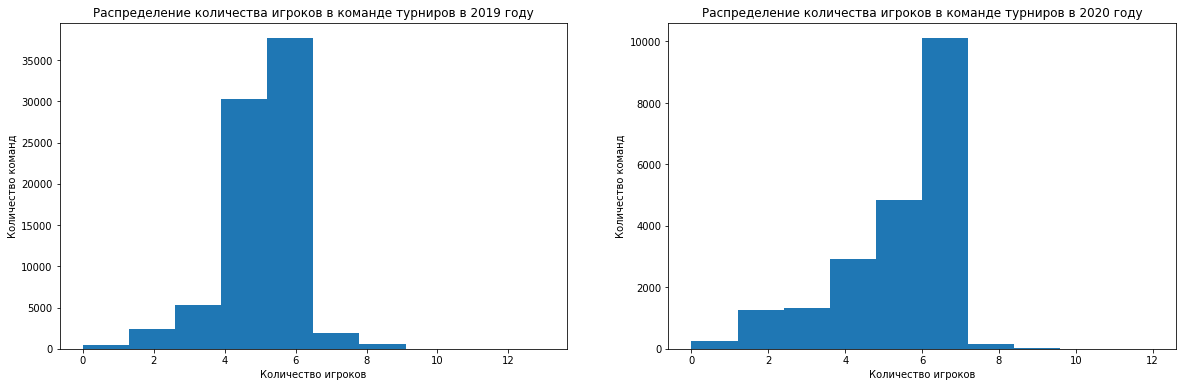

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

teams_size_train = [len(t['team_members']) for v in results_train.values() for t in v['teams'].values()]
teams_size_test = [len(t['team_members']) for v in results_test.values() for t in v['teams'].values()]

ax1.hist(teams_size_train)
ax1.set_title('Распределение количества игроков в команде турниров в 2019 году')
ax1.set_xlabel('Количество игроков')
ax1.set_ylabel('Количество команд')

ax2.hist(teams_size_test)
ax2.set_title('Распределение количества игроков в команде турниров в 2020 году')
ax2.set_xlabel('Количество игроков')
ax2.set_ylabel('Количество команд');

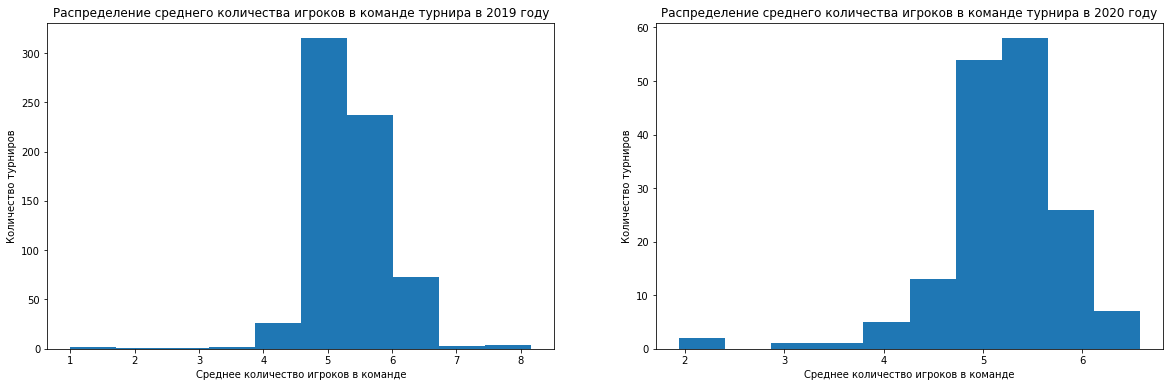

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

tour_teams_size_train = [np.mean([len(t['team_members']) for t in v['teams'].values()]) for v in results_train.values()]
tour_teams_size_test = [np.mean([len(t['team_members']) for t in v['teams'].values()]) for v in results_test.values()]

ax1.hist(tour_teams_size_train)
ax1.set_title('Распределение среднего количества игроков в команде турнира в 2019 году')
ax1.set_xlabel('Среднее количество игроков в команде')
ax1.set_ylabel('Количество турниров')

ax2.hist(tour_teams_size_test)
ax2.set_title('Распределение среднего количества игроков в команде турнира в 2020 году')
ax2.set_xlabel('Среднее количество игроков в команде')
ax2.set_ylabel('Количество турниров');

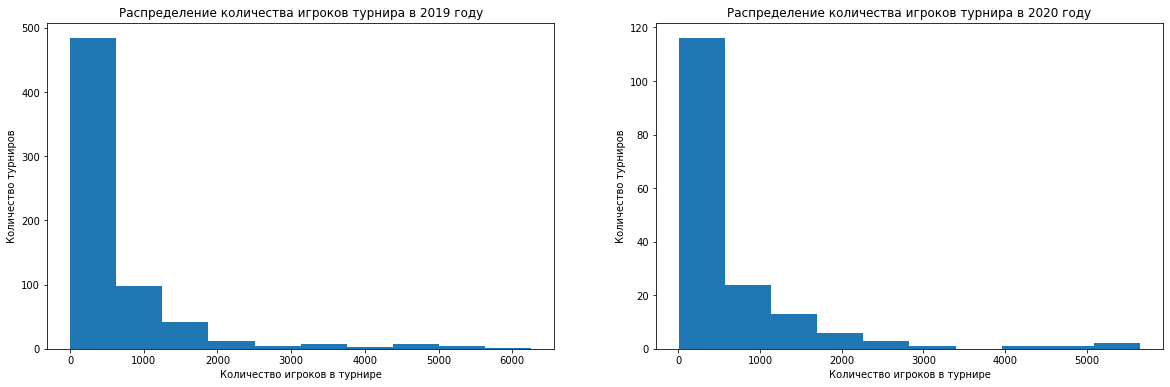

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

tour_players_size_train = [np.sum([len(t['team_members']) for t in v['teams'].values()]) for v in results_train.values()]
tour_players_size_test = [np.sum([len(t['team_members']) for t in v['teams'].values()]) for v in results_test.values()]

ax1.hist(tour_players_size_train)
ax1.set_title('Распределение количества игроков турнира в 2019 году')
ax1.set_xlabel('Количество игроков в турнире')
ax1.set_ylabel('Количество турниров')

ax2.hist(tour_players_size_test)
ax2.set_title('Распределение количества игроков турнира в 2020 году')
ax2.set_xlabel('Количество игроков в турнире')
ax2.set_ylabel('Количество турниров');

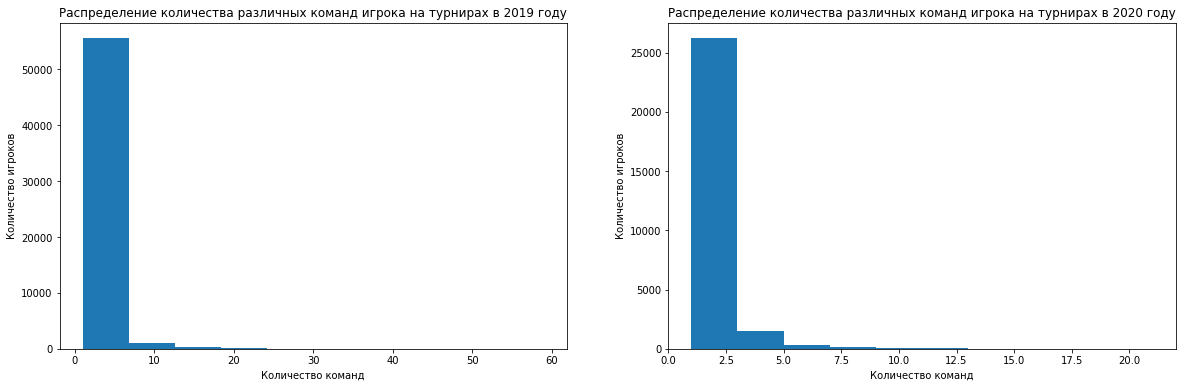

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

players_teams_train = player_teams_cnt(results_train)
players_teams_test = player_teams_cnt(results_test)

ax1.hist(players_teams_train)
ax1.set_title('Распределение количества различных команд игрока на турнирах в 2019 году')
ax1.set_xlabel('Количество команд')
ax1.set_ylabel('Количество игроков')

ax2.hist(players_teams_test)
ax2.set_title('Распределение количества различных команд игрока на турнирах в 2020 году')
ax2.set_xlabel('Количество команд')
ax2.set_ylabel('Количество игроков');

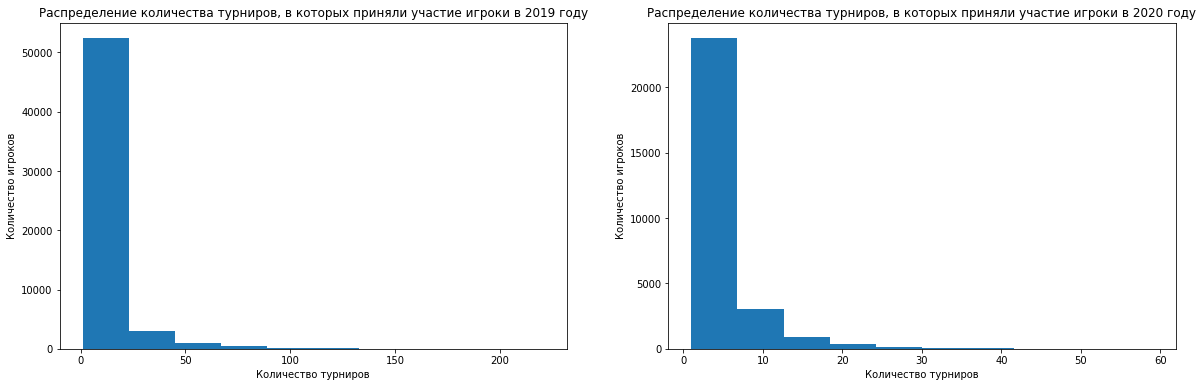

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

players_tours_train = player_tours_cnt(results_train)
players_tours_test = player_tours_cnt(results_test)

ax1.hist(players_tours_train)
ax1.set_title('Распределение количества турниров, в которых приняли участие игроки в 2019 году')
ax1.set_xlabel('Количество турниров')
ax1.set_ylabel('Количество игроков')

ax2.hist(players_tours_test)
ax2.set_title('Распределение количества турниров, в которых приняли участие игроки в 2020 году')
ax2.set_xlabel('Количество турниров')
ax2.set_ylabel('Количество игроков');

In [25]:
questions_train = np.sum([np.mean([len(t['mask']) for t in v['teams'].values()]) for v in results_train.values()])
questions_test = np.sum([np.mean([len(t['mask']) for t in v['teams'].values()]) for v in results_test.values()])

mean_questions_size_train = np.mean([np.mean([len(t['mask']) for t in v['teams'].values()]) for v in results_train.values()])
mean_questions_size_test = np.mean([np.mean([len(t['mask']) for t in v['teams'].values()]) for v in results_test.values()])

print(f'Всего вопросов в 2019 году: {questions_train}')
print(f'Всего вопросов в 2020 году: {questions_test}')
print(f'Среднее количество вопросов в турнире 2019 года: {mean_questions_size_train:.2f}')
print(f'Среднее количество вопросов в турнире 2020 года: {mean_questions_size_test:.2f}')

Всего вопросов в 2019 году: 30958.0
Всего вопросов в 2020 году: 7394.0
Среднее количество вопросов в турнире 2019 года: 46.62
Среднее количество вопросов в турнире 2020 года: 44.28


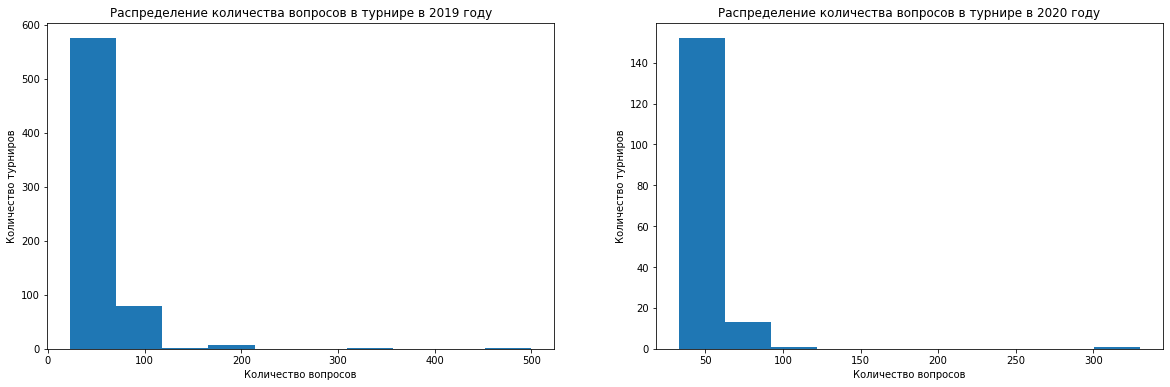

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

questions_in_tour_train = [np.mean([len(t['mask']) for t in v['teams'].values()]) for v in results_train.values()]
questions_in_tour_test = [np.mean([len(t['mask']) for t in v['teams'].values()]) for v in results_test.values()]

ax1.hist(questions_in_tour_train)
ax1.set_title('Распределение количества вопросов в турнире в 2019 году')
ax1.set_xlabel('Количество вопросов')
ax1.set_ylabel('Количество турниров')

ax2.hist(questions_in_tour_test)
ax2.set_title('Распределение количества вопросов в турнире в 2020 году')
ax2.set_xlabel('Количество вопросов')
ax2.set_ylabel('Количество турниров');

2.	Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
* в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

In [27]:
n_answers = 0
for v in results_train.values():
    for t in v['teams'].values():
        n_answers += len(t['team_members']) * len(t['mask'])
        
n_answers

16177620

In [28]:
all_players = set([p for v in results_train.values() for t in v['teams'].values() for p in t['team_members']])
player_to_idx = {player: idx for idx, player in enumerate(all_players)}
idx_to_player = {idx: player for player, idx in player_to_idx.items()}

In [29]:
y = []
question_player = []
question_ids = []
team_ids = []
question_to_tournament = dict()

max_question_id = -1

for tournament_id, tournament in results_train.items(): 
    for team_id, team in tournament['teams'].items():
        for question_id, answer in enumerate(team['mask'], 1):
            question_id += max_question_id
            question_to_tournament[question_id] = tournament_id
            
            for player in team['team_members']:
                player_id = player_to_idx[player] + questions_train
                question_player.append((question_id, player_id))
                y.append(int(answer))
                question_ids.append(question_id)
                team_ids.append(team_id)
                
    max_question_id = question_id

In [30]:
row = []
col = []
data = []

for row_id, (question_id, player_id) in enumerate(question_player):
    row.append(row_id)
    col.append(question_id)
    data.append(1)
    
    row.append(row_id)
    col.append(player_id)
    data.append(1)

n_rows = int(n_answers)
n_cols = int(questions_train + players_train)
X = scipy.sparse.coo_matrix((data, (row, col)), shape=(n_rows, n_cols))

In [31]:
lr = LogisticRegression(random_state=0, solver='liblinear')
lr.fit(X, y)

LogisticRegression(random_state=0, solver='liblinear')

In [32]:
def build_players_raiting(model_scores):
    player_ratings = dict()
    for idx, score in enumerate(model_scores[int(questions_train):]):
        player_ratings[idx_to_player[idx]] = score
        
    df_player_ratings = pd.DataFrame.from_dict(player_ratings, orient='index')
    df_player_ratings.reset_index(inplace=True)
    df_player_ratings.columns = ['id', 'score']
    df_player_ratings.sort_values('score', ascending=False, inplace=True)
    df_player_ratings.reset_index(drop=True, inplace=True)
    df_player_ratings = df_player_ratings.merge(players, on='id')
    return player_ratings, df_player_ratings

In [33]:
baseline_players_rating, df_baseline_players_rating = build_players_raiting(lr.coef_[0])
df_baseline_players_rating.head(20)

,id,score,name,patronymic,surname
0,27403,4.158274,Максим,Михайлович,Руссо
1,4270,4.028645,Александра,Владимировна,Брутер
2,28751,3.986213,Иван,Николаевич,Семушин
3,27822,3.898984,Михаил,Владимирович,Савченков
4,30152,3.817149,Артём,Сергеевич,Сорожкин
5,30270,3.817068,Сергей,Леонидович,Спешков
6,20691,3.699564,Станислав,Григорьевич,Мереминский
7,18036,3.643254,Михаил,Ильич,Левандовский
8,26089,3.573353,Ирина,Сергеевна,Прокофьева
9,22799,3.569481,Сергей,Игоревич,Николенко


3.	Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
* предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
* в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров .

В качестве способа предсказания результатов будущих турниров можно предложить усреднение оценок силы каждого из участников команды.

In [34]:
def build_tournaments_rating(players_rating):
    tour_position_rating = dict()
    for k, v in results_test.items():
        teams_position_rating = dict()
        for t_id, t in v['teams'].items():
            scores = [players_rating.get(p) for p in t['team_members']]
            scores = [sc for sc in scores if sc]
            if scores:
                pred_rating = np.mean(scores)
                pos = t['position']
                teams_position_rating[t_id] = {'position': pos, 'score': pred_rating}
        tour_position_rating[k] = teams_position_rating
    return tour_position_rating

In [35]:
baseline_tournaments_rating = build_tournaments_rating(baseline_players_rating)

In [36]:
def tournament_rating_example(tournaments_rating):
    tournament_id = list(tournaments_rating.keys())[0]
    tournament_rating = pd.DataFrame.from_dict(tournaments_rating[tournament_id], orient='index')
    tournament_rating.reset_index(inplace=True)
    tournament_rating.columns = ['id', 'position', 'score']
    tournament_rating['team_name'] = tournament_rating['id'].map(lambda x: teams[x])
    tournament_rating.sort_values('score', ascending=False, inplace=True)
    tournament_rating.reset_index(drop=True, inplace=True)
    return tournament_rating

In [37]:
baseline_tournament_rating_example = tournament_rating_example(baseline_tournaments_rating)
baseline_tournament_rating_example.head(20)

,id,position,score,team_name
0,49804,1.0,3.951056,Борский корабел
1,45367,5.5,3.392401,Гвардия
2,77418,4.0,3.261392,Лучший МС IV раунда сетки Инь по версии фломас...
3,27177,22.0,3.231439,Призраки Коши
4,2,5.5,3.228858,Афина
5,46381,31.5,3.179097,Разведка боём
6,76134,22.0,2.994993,Сборник хз
7,27522,22.0,2.946711,Жареные гвозди
8,4109,2.0,2.924919,Первая сборная
9,62868,15.5,2.835902,Gay Guerrilla


In [38]:
def rating_metrics(tournaments_rating):
    spearman_corrs = []
    kendall_corrs = []
    
    for v in tournaments_rating.values():
        position_list = []
        pred_rating_list = []
        
        for t in v.values():
            position_list.append(t['position'])
            pred_rating_list.append(-t['score'])
        
        spearman_corrs.append(scipy.stats.spearmanr(position_list, pred_rating_list, nan_policy='omit')[0])
        kendall_corrs.append(scipy.stats.kendalltau(position_list, pred_rating_list, nan_policy='omit')[0])
    return np.mean(spearman_corrs), np.mean(kendall_corrs)

In [39]:
mean_spearman, mean_kendall = rating_metrics(baseline_tournaments_rating)
print(f'Корреляция Спирмена: {mean_spearman}')
print(f'Корреляция Кендалла: {mean_kendall}')

Корреляция Спирмена: 0.7796425179329474
Корреляция Кендалла: 0.6243196635860275


4.	Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
* предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

В качестве скрытой переменной можно взять вероятность правильного ответа игрока при условии, что команда ответила правильно:

$y_j$ - ответ j-ой команды

$x_i$ - ответ i-го игрока команды j

$$ y_j=0 \Rightarrow x_i=0 \Rightarrow z_i=0 $$

$$ z_i=P(x_i=1|y_j=1)=\frac{P(y_j=1|x_i=1)P(x_i=1)}{P(y_j=1)}=\frac{P(x_i=1)}{P(y_j=1)} $$

$P(x_i=1)$ можно моделировать как предсказание логистической регрессии

$$ P(y_j=1)=1-\prod_{i=1}^{n_j}(1-P(x_i=1)) $$

In [40]:
class LogitRegression(LinearRegression):

    def fit(self, x, p, e = 1e-16):
        p = np.asarray(p)
        y = np.log((p + e) / (1 - p + e))
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)
    
    def predict_proba(self, x):
        prob_1 = self.predict(x).reshape(-1, 1)
        prob_0 = (1 - prob_1).reshape(-1, 1)
        prob = np.hstack((prob_0, prob_1))
        return prob

In [41]:
em_lr = LogitRegression()
em_lr.fit(X, y)

LogitRegression()

In [42]:
em_players_rating, _ = build_players_raiting(em_lr.coef_)
em_tournaments_rating = build_tournaments_rating(em_players_rating)
mean_spearman, mean_kendall = rating_metrics(em_tournaments_rating)
print(f'Корреляция Спирмена: {mean_spearman}')
print(f'Корреляция Кендалла: {mean_kendall}')

Корреляция Спирмена: 0.7766335222705691
Корреляция Кендалла: 0.6201906067133901


In [43]:
e = 1e-16

for i in range(5):
    print(f'Итерация: {i}')
    
    # E-шаг
    player_prob = em_lr.predict_proba(X)
    player_prob_0, player_prob_1 = player_prob[:, 0], player_prob[:, 1]
            
    players_prob = pd.DataFrame({
        'team': team_ids, 
        'question': question_ids, 
        'player_prob_0': player_prob_0,
        'player_prob_1': player_prob_1, 
    })
    
    teams_prob = players_prob.groupby(['team', 'question'])['player_prob_0'].prod().reset_index()
    teams_prob.columns = ['team', 'question', 'team_prob_0']
    teams_prob['team_prob_1'] = 1 - teams_prob['team_prob_0']
    
    players_prob = players_prob.merge(teams_prob, on=['team', 'question'])
    z = (players_prob['player_prob_1'] / (players_prob['team_prob_1'] + e)).values
    z[y == 0] = 0
    
    # M-шаг
    em_lr.fit(X, z)
    
    # Метрики
    em_players_rating, df_em_players_rating = build_players_raiting(em_lr.coef_)
    em_tournaments_rating = build_tournaments_rating(em_players_rating)
    mean_spearman, mean_kendall = rating_metrics(em_tournaments_rating)
    print(f'Корреляция Спирмена: {mean_spearman}')
    print(f'Корреляция Кендалла: {mean_kendall}')

Итерация: 0
Корреляция Спирмена: 0.7709731502404333
Корреляция Кендалла: 0.6106794446709234
Итерация: 1
Корреляция Спирмена: 0.7540659201912457
Корреляция Кендалла: 0.592767035724959
Итерация: 2
Корреляция Спирмена: 0.7389336187288672
Корреляция Кендалла: 0.5767377701786683
Итерация: 3
Корреляция Спирмена: 0.7273651888147589
Корреляция Кендалла: 0.5668922788299745
Итерация: 4
Корреляция Спирмена: 0.7203119462927215
Корреляция Кендалла: 0.561029363742947


In [44]:
df_em_players_rating.head(20)

,id,score,name,patronymic,surname
0,212298,37.959024,Анна,,Осетрова
1,191740,36.757440,Олеся,,Буздалова
2,192193,36.757440,Даниил,Александрович,Ганик
3,161382,36.757440,Максим,,Слободзяный
4,166181,36.757440,Даниил,Сергеевич,Осока
5,168282,35.813814,Анастасия,Сергеевна,Седохина
6,160946,35.563810,Илья,Олегович,Ушаков
7,206021,35.088387,Павел,Владимирович,Тарасов
8,22474,34.415701,Илья,Сергеевич,Немец
9,30527,34.238073,Николай,,Степанюк


In [45]:
em_tournament_rating_example = tournament_rating_example(em_tournaments_rating)
em_tournament_rating_example.head(20)

,id,position,score,team_name
0,49804,1.0,17.310552,Борский корабел
1,45367,5.5,14.732275,Гвардия
2,27177,22.0,14.406799,Призраки Коши
3,2,5.5,13.842717,Афина
4,77418,4.0,13.801479,Лучший МС IV раунда сетки Инь по версии фломас...
5,46381,31.5,13.620913,Разведка боём
6,76134,22.0,12.853717,Сборник хз
7,3875,3.0,12.261002,Сова при свете дня
8,4109,2.0,11.973405,Первая сборная
9,63409,63.5,11.853110,Бражники


5.	А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? 

In [46]:
tournaments_quetsion_rating = defaultdict(list)
for idx, rating in enumerate(em_lr.coef_[:int(questions_train)]):
    tournaments_quetsion_rating[question_to_tournament[idx]].append(rating)

tournaments_rating = dict()
for tournament_id, scores in tournaments_quetsion_rating.items():
    tournaments_rating[tournament_id] = np.mean(scores)

df_tour_rating = pd.DataFrame.from_dict(tournaments_rating, orient='index')
df_tour_rating.reset_index(inplace=True)
df_tour_rating.columns = ['tournament_id', 'score']
df_tour_rating.sort_values('score', inplace=True)
df_tour_rating.reset_index(drop=True, inplace=True)
df_tour_rating['tournament_name'] = df_tour_rating['tournament_id'].map(lambda x: results_train[x]['name'])
df_tour_rating.head(20)

,tournament_id,score,tournament_name
0,6149,-10.924755,Чемпионат Санкт-Петербурга. Первая лига
1,5946,-10.184442,Чемпионат Мира. Этап 3. Группа В
2,5947,-9.645415,Чемпионат Мира. Этап 3. Группа С
3,5950,-9.397657,Чемпионат Мира. Финал. Группа С
4,5928,-9.251057,Угрюмый Ёрш
5,5942,-8.557478,Чемпионат Мира. Этап 2. Группа В
6,5949,-8.494168,Чемпионат Мира. Финал. Группа В
7,5943,-8.254034,Чемпионат Мира. Этап 2 Группа С
8,5465,-8.186449,Чемпионат России
9,5684,-8.122295,Синхрон высшей лиги Москвы


In [47]:
df_tour_rating.tail(20)

,tournament_id,score,tournament_name
644,5729,9.076201,Синхрон-lite. Выпуск XXX
645,5679,9.080641,Чемпионат Караганды
646,5313,9.235448,(а)Синхрон-lite. Лига старта. Эпизод VI
647,5935,9.261923,Асинхрон по «Королю и Шуту»
648,5388,9.281707,Олимпиада Приволжского федерального округа. Финал
649,5698,9.611946,(а)Синхрон-lite. Лига старта. Эпизод VII
650,6145,9.772431,Кубок Караганды
651,5702,10.103487,(а)Синхрон-lite. Лига старта. Эпизод IX
652,5704,10.383296,(а)Синхрон-lite. Лига старта. Эпизод X
653,5009,10.627904,(а)Синхрон-lite. Лига старта. Эпизод III


В топе турниров по сложности вопросов много чемпионатов мира и крупных городов. Среди самых легких турниров встречаются студенческие чемпионаты. В целом рейтинг турниров по сложности вопросов соответствует интуиции. 